# Kymo VAE!

**NOTICE**: Don't edit this file, I'm starting over from scratch because I don't understand the errors we are getting RIP

In [36]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import json
import torch
from abc import abstractmethod
from torch import nn
from torch.nn import functional as F
from types import *
from matplotlib import pyplot as plt

In [37]:
### Paths ###

parent_folder = 'C:/Users/Aidan/Documents/Winter_2023/BE177B/Code/'
art_json = parent_folder + 'wonglab-capstone/Datateam/Artificial_imset/artificial_kymographs.json'
exp_json = parent_folder + 'wonglab-capstone/Datateam/imset1/experimental_kymograph.json'

In [38]:
class ArtKymoDataset(Dataset):
    def __init__(self):
        #data loading
        with open(art_json, 'r') as f:
            kymos = np.asarray(json.loads(f.read())["kymoset"])
        kymos = kymos.astype('float32')
        kymos = torch.from_numpy(kymos)
        # self.x = kymos[:,None,:,:]
        self.x = kymos
        self.x = self.x[:,None,:,:]
        self.n_samples = kymos.shape[0]

    def __getitem__(self, index):
        return self.x[index,:,:]

    def __len__(self):
        return self.n_samples

In [39]:
class BaseVAE(nn.Module):
    
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: torch.Tensor) -> list[torch.Tensor]:
        raise NotImplementedError

    def decode(self, input: torch.Tensor) -> any:
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: int, **kwargs) -> torch.Tensor:
        raise NotImplementedError

    def generate(self, x: torch.Tensor, **kwargs) -> torch.Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: torch.Tensor) -> torch.Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: any, **kwargs) -> torch.Tensor:
        pass

In [71]:
class KymoVAE(BaseVAE):

    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: list = None,
                 **kwargs) -> None:
                 
        super(KymoVAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*8, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*8, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 8)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 1,
                                      kernel_size= 3, padding= 1),
                            nn.LeakyReLU(),
                            nn.Linear(hidden_dims[-1]*2, out_features=60),
                            nn.Tanh())

    def encode(self, input: torch.Tensor) -> list[torch.Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input Tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        # result = result.view(-1, 512, 2, 2)
        result = result.view(-1, 256, 2, 4)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: torch.Tensor, **kwargs) -> list[torch.Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> torch.Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [72]:
batch_size = 5

dataset = ArtKymoDataset()
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
# print(ArtKymoDataset.__len__(dataset))

# dataiter = iter(dataloader)
# data = dataiter._next_data()

# print(data.shape)

# #display first batch!
# print(len(data))

# #training loop
# num_epochs = 2
# total_samples = len(dataset)
# n_iterations = math.ceil(total_samples/batch_size)

# for epoch in range(num_epochs):
#     for i, inputs in enumerate(dataloader):
#             print(inputs.size())
#             print(inputs)

# for epoch in range(num_epochs):
#     for i, inputs in enumerate(dataloader):
#         #forward, backward, update
#         if (i+1) % 5 == 0:
#             print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_iterations}, inputs {inputs.shape}') #summary for debugging

In [77]:
num_epochs = 1
model = KymoVAE(in_channels = 1, latent_dim = 20, hidden_dims = [32, 64, 128, 256])

for epoch in range(num_epochs):
    for i, inputs in enumerate(dataloader):
            print(inputs.size())
            latent_kymos = model.encode(inputs)
            reconstructed_kymos = model.decode(latent_kymos[0])
            
result = reconstructed_kymos.detach().numpy()
print(latent_kymos[0].size())
print(np.shape(result))



    # for i, inputs in enumerate(dataloader):
    #     #forward, backward, update
    #     if (i+1) % 5 == 0:
    #         print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_iterations}, inputs {inputs.shape}') #summary for debugging

torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
torch.Size([5, 1, 20, 60])
t

In [55]:
for epoch in range(num_epochs):
    for i, inputs in enumerate(dataloader):
            gen_im = model.generate(inputs)

result = gen_im.detach().numpy()
np.shape(result)

(5, 1, 32, 64)

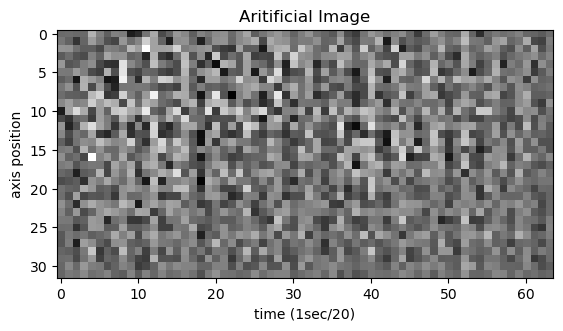

In [56]:
plt.title('Aritificial Image')
plt.xlabel('time (1sec/20)')
plt.ylabel('axis position')
plt.imshow(result[0,0,:,:], cmap='gray', interpolation='nearest')